In [295]:
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import SVG, Image
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

In [296]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

In [297]:
PATH = 'dataset/train/'

In [298]:
train_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.


Using 576 files for training.
['caribou', 'deer', 'elk', 'moose']


In [299]:
val_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [300]:
test_ds = image_dataset_from_directory(
  'dataset/test/',
  seed=123,
  image_size=(224, 224))

print(test_ds.class_names)

Found 160 files belonging to 4 classes.


['caribou', 'deer', 'elk', 'moose']


In [301]:
class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE

In [302]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(224,224,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=0.1,fill_mode='nearest'),
                                          tf.keras.layers.RandomBrightness(0.2),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

In [303]:
c = 0
for x,y in train_ds:
    # print(x.shape)
    # print(x)
    # print(y)
    c += len(x)
print(c)

576


In [304]:
augmented_train = train_ds.map(lambda x,y: (dataaug(x,training=True),y))

2023-10-27 22:37:54.018520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


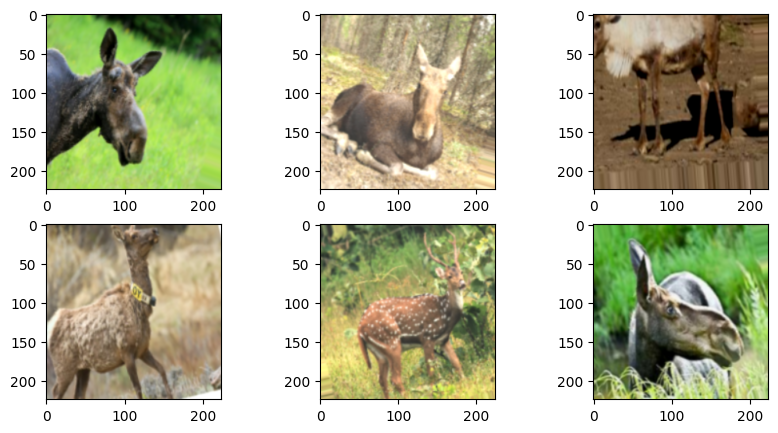

In [305]:
# show original vs resized
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
for images, labels in augmented_train:
    for i in range(6):
        ax[i].imshow(images[i])

In [142]:
full_train_ds = train_ds.concatenate(augmented_train)

In [146]:
c = 0
for x,y in full_train_ds:
    c += len(x)
print(c)

2023-10-27 20:15:42.283098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


896


In [147]:
train_dataset = full_train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

In [151]:
base_model = ResNet152V2(input_shape=(224,224,3), 
                         include_top=True,
                         weights="imagenet")

In [152]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_19[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [153]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
val_ds = val_ds.map(preprocess)

In [101]:
# plot_model(base_model, to_file='model.png', show_shapes=True, show_layer_names=True)
# Image('model.png',width=400, height=200)

In [163]:
# Defining Callbacks

filepath = 'resnet_callback/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [167]:
# Model Compile 

OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

base_model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [168]:
model_history=base_model.fit(train_dataset,
                        validation_data=val_ds,
                        epochs = 30,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/30


2023-10-27 20:35:38.835749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/28 [===>..........................] - ETA: 39s - loss: 4.8476 - accuracy: 0.2891   

2023-10-27 20:37:06.423626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.8839 - accuracy: 0.5145

2023-10-27 20:37:33.309623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.28646, saving model to resnet_callback/best_weights.hdf5


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 151s 2s/step - loss: 1.8839 - accuracy: 0.5145 - val_loss: 166183.3594 - val_accuracy: 0.2865
Epoch 2/30
 4/28 [===>..........................] - ETA: 27s - loss: 1.0345 - accuracy: 0.6641

2023-10-27 20:38:11.122788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.8895 - accuracy: 0.6819
Epoch 2: val_accuracy did not improve from 0.28646
28/28 [==============================] - 38s 1s/step - loss: 0.8895 - accuracy: 0.6819 - val_loss: 1972.7540 - val_accuracy: 0.2500
Epoch 3/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.4639 - accuracy: 0.8281

2023-10-27 20:38:47.144732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7645
Epoch 3: val_accuracy did not improve from 0.28646
28/28 [==============================] - 34s 1s/step - loss: 0.6810 - accuracy: 0.7645 - val_loss: 20.8558 - val_accuracy: 0.2865
Epoch 4/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.5795 - accuracy: 0.7812

2023-10-27 20:39:20.948712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.7812
Epoch 4: val_accuracy improved from 0.28646 to 0.33854, saving model to resnet_callback/best_weights.hdf5
28/28 [==============================] - 35s 1s/step - loss: 0.6120 - accuracy: 0.7812 - val_loss: 8.5910 - val_accuracy: 0.3385
Epoch 5/30
 4/28 [===>..........................] - ETA: 26s - loss: 0.3257 - accuracy: 0.8984

2023-10-27 20:39:57.049123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.8371
Epoch 5: val_accuracy did not improve from 0.33854
28/28 [==============================] - 35s 1s/step - loss: 0.4856 - accuracy: 0.8371 - val_loss: 6.2926 - val_accuracy: 0.3125
Epoch 6/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.4051 - accuracy: 0.8594

2023-10-27 20:40:31.033914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.4757 - accuracy: 0.8471
Epoch 6: val_accuracy did not improve from 0.33854
28/28 [==============================] - 34s 1s/step - loss: 0.4757 - accuracy: 0.8471 - val_loss: 34.3353 - val_accuracy: 0.3021
Epoch 7/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.3649 - accuracy: 0.9062

2023-10-27 20:41:05.130634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8449
Epoch 7: val_accuracy did not improve from 0.33854
28/28 [==============================] - 34s 1s/step - loss: 0.4365 - accuracy: 0.8449 - val_loss: 13.4886 - val_accuracy: 0.2865
Epoch 8/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.2508 - accuracy: 0.9453

2023-10-27 20:41:39.054301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8728
Epoch 8: val_accuracy improved from 0.33854 to 0.45833, saving model to resnet_callback/best_weights.hdf5
28/28 [==============================] - 36s 1s/step - loss: 0.3987 - accuracy: 0.8728 - val_loss: 2.1586 - val_accuracy: 0.4583
Epoch 9/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.2035 - accuracy: 0.9531

2023-10-27 20:42:14.978117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8571
Epoch 9: val_accuracy improved from 0.45833 to 0.52604, saving model to resnet_callback/best_weights.hdf5
28/28 [==============================] - 38s 1s/step - loss: 0.4139 - accuracy: 0.8571 - val_loss: 3.1952 - val_accuracy: 0.5260
Epoch 10/30
 4/28 [===>..........................] - ETA: 26s - loss: 0.2331 - accuracy: 0.9141

2023-10-27 20:42:53.313408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.8694
Epoch 10: val_accuracy did not improve from 0.52604
28/28 [==============================] - 36s 1s/step - loss: 0.4006 - accuracy: 0.8694 - val_loss: 18.7262 - val_accuracy: 0.3125
Epoch 11/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.2113 - accuracy: 0.9531

2023-10-27 20:43:28.762037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8951
Epoch 11: val_accuracy improved from 0.52604 to 0.64583, saving model to resnet_callback/best_weights.hdf5
28/28 [==============================] - 36s 1s/step - loss: 0.3345 - accuracy: 0.8951 - val_loss: 2.4260 - val_accuracy: 0.6458
Epoch 12/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.1543 - accuracy: 0.9531

2023-10-27 20:44:04.514062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.8917
Epoch 12: val_accuracy did not improve from 0.64583
28/28 [==============================] - 35s 1s/step - loss: 0.3373 - accuracy: 0.8917 - val_loss: 1.8006 - val_accuracy: 0.5729
Epoch 13/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.1573 - accuracy: 0.9453

2023-10-27 20:44:39.256357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.8929
Epoch 13: val_accuracy did not improve from 0.64583
28/28 [==============================] - 34s 1s/step - loss: 0.3115 - accuracy: 0.8929 - val_loss: 5.0411 - val_accuracy: 0.3958
Epoch 14/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.1507 - accuracy: 0.9297

2023-10-27 20:45:13.578654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8850
Epoch 14: val_accuracy did not improve from 0.64583
28/28 [==============================] - 34s 1s/step - loss: 0.3416 - accuracy: 0.8850 - val_loss: 4.4332 - val_accuracy: 0.4531
Epoch 15/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.1557 - accuracy: 0.9453

2023-10-27 20:45:47.753566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9152
Epoch 15: val_accuracy did not improve from 0.64583
28/28 [==============================] - 35s 1s/step - loss: 0.2488 - accuracy: 0.9152 - val_loss: 2.9486 - val_accuracy: 0.5677
Epoch 16/30
 4/28 [===>..........................] - ETA: 27s - loss: 0.0917 - accuracy: 0.9688

2023-10-27 20:46:23.817560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9241
Epoch 16: val_accuracy did not improve from 0.64583
28/28 [==============================] - 36s 1s/step - loss: 0.2220 - accuracy: 0.9241 - val_loss: 5.8768 - val_accuracy: 0.4896
Epoch 17/30
 4/28 [===>..........................] - ETA: 27s - loss: 0.0497 - accuracy: 0.9922

2023-10-27 20:47:00.743948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8929
Epoch 17: val_accuracy did not improve from 0.64583
28/28 [==============================] - 37s 1s/step - loss: 0.3083 - accuracy: 0.8929 - val_loss: 2.2206 - val_accuracy: 0.6198
Epoch 18/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.1031 - accuracy: 0.9688

2023-10-27 20:47:36.278063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.9018
Epoch 18: val_accuracy did not improve from 0.64583
28/28 [==============================] - 34s 1s/step - loss: 0.2934 - accuracy: 0.9018 - val_loss: 2.9984 - val_accuracy: 0.5625
Epoch 19/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.0726 - accuracy: 0.9844

2023-10-27 20:48:10.502977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9107
Epoch 19: val_accuracy did not improve from 0.64583
28/28 [==============================] - 34s 1s/step - loss: 0.2590 - accuracy: 0.9107 - val_loss: 2.1882 - val_accuracy: 0.5469
Epoch 20/30
 4/28 [===>..........................] - ETA: 26s - loss: 0.0857 - accuracy: 0.9766

2023-10-27 20:48:45.558455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9040
Epoch 20: val_accuracy improved from 0.64583 to 0.69792, saving model to resnet_callback/best_weights.hdf5
28/28 [==============================] - 38s 1s/step - loss: 0.2807 - accuracy: 0.9040 - val_loss: 1.2206 - val_accuracy: 0.6979
Epoch 21/30
 4/28 [===>..........................] - ETA: 32s - loss: 0.1174 - accuracy: 0.9609

2023-10-27 20:49:25.278359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9308
Epoch 21: val_accuracy did not improve from 0.69792
28/28 [==============================] - 39s 1s/step - loss: 0.2007 - accuracy: 0.9308 - val_loss: 1.1552 - val_accuracy: 0.6979
Epoch 22/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.0900 - accuracy: 0.9766

2023-10-27 20:50:02.043570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.9118
Epoch 22: val_accuracy did not improve from 0.69792
28/28 [==============================] - 34s 1s/step - loss: 0.2499 - accuracy: 0.9118 - val_loss: 1.7096 - val_accuracy: 0.5990
Epoch 23/30
 4/28 [===>..........................] - ETA: 28s - loss: 0.0696 - accuracy: 0.9844

2023-10-27 20:50:36.732102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9342
Epoch 23: val_accuracy improved from 0.69792 to 0.71354, saving model to resnet_callback/best_weights.hdf5
28/28 [==============================] - 38s 1s/step - loss: 0.1966 - accuracy: 0.9342 - val_loss: 1.1200 - val_accuracy: 0.7135
Epoch 24/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.0635 - accuracy: 0.9766

2023-10-27 20:51:13.965560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9420
Epoch 24: val_accuracy did not improve from 0.71354
28/28 [==============================] - 35s 1s/step - loss: 0.1773 - accuracy: 0.9420 - val_loss: 1.2416 - val_accuracy: 0.6823
Epoch 25/30
 4/28 [===>..........................] - ETA: 26s - loss: 0.0295 - accuracy: 0.9922

2023-10-27 20:51:48.478921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9487
Epoch 25: val_accuracy did not improve from 0.71354
28/28 [==============================] - 35s 1s/step - loss: 0.1520 - accuracy: 0.9487 - val_loss: 3.4668 - val_accuracy: 0.4792
Epoch 26/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.0425 - accuracy: 0.9922

2023-10-27 20:52:23.272213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9364
Epoch 26: val_accuracy improved from 0.71354 to 0.73438, saving model to resnet_callback/best_weights.hdf5
28/28 [==============================] - 36s 1s/step - loss: 0.1617 - accuracy: 0.9364 - val_loss: 1.4244 - val_accuracy: 0.7344
Epoch 27/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.0529 - accuracy: 0.9844

2023-10-27 20:52:59.670833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9442
Epoch 27: val_accuracy did not improve from 0.73438
28/28 [==============================] - 35s 1s/step - loss: 0.1724 - accuracy: 0.9442 - val_loss: 1.2497 - val_accuracy: 0.6823
Epoch 28/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.0828 - accuracy: 0.9844

2023-10-27 20:53:33.980109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9520
Epoch 28: val_accuracy did not improve from 0.73438
28/28 [==============================] - 34s 1s/step - loss: 0.1526 - accuracy: 0.9520 - val_loss: 3.5175 - val_accuracy: 0.5365
Epoch 29/30
 4/28 [===>..........................] - ETA: 24s - loss: 0.0445 - accuracy: 0.9844

2023-10-27 20:54:08.281126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9453
Epoch 29: val_accuracy did not improve from 0.73438
28/28 [==============================] - 34s 1s/step - loss: 0.1655 - accuracy: 0.9453 - val_loss: 1.5531 - val_accuracy: 0.7031
Epoch 30/30
 4/28 [===>..........................] - ETA: 25s - loss: 0.0835 - accuracy: 0.9766

2023-10-27 20:54:42.870762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9397
Epoch 30: val_accuracy did not improve from 0.73438
28/28 [==============================] - 34s 1s/step - loss: 0.1761 - accuracy: 0.9397 - val_loss: 2.0089 - val_accuracy: 0.6875


In [170]:
history = base_model.history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

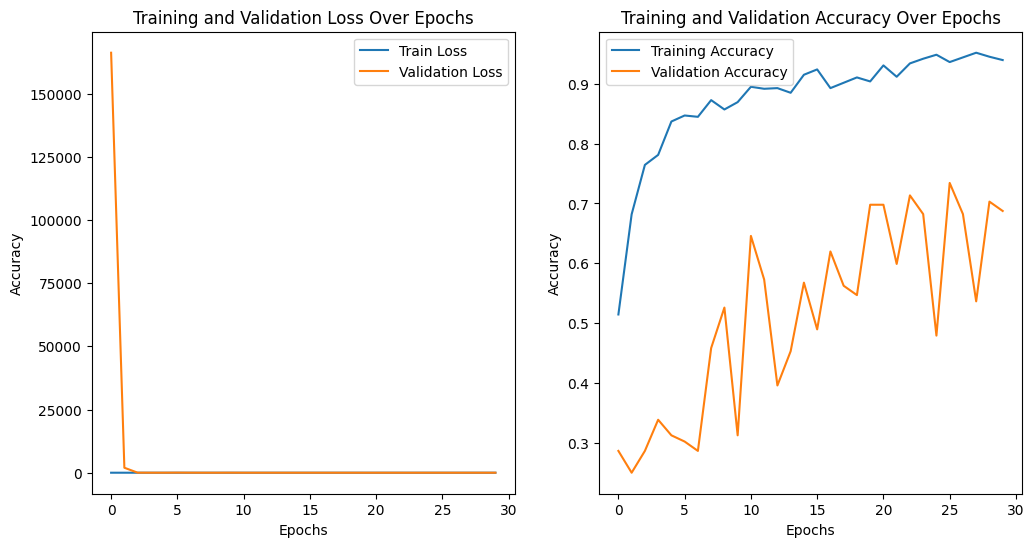

In [171]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [198]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [199]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [200]:
last_conv_layer_name = "conv5_block3_out"

In [201]:
grad_cam_img_path = 'dataset/train/caribou/Male_Caribou17.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, base_model, last_conv_layer_name)

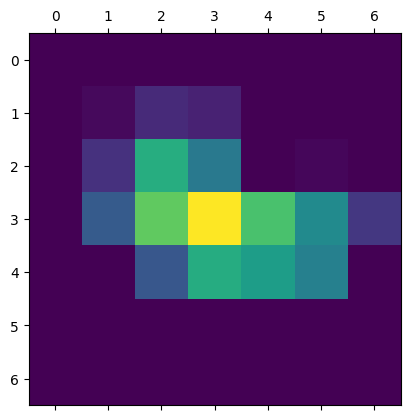

In [202]:
plt.matshow(heatmap)
plt.show()

/var/folders/v5/n7zzf9t13vn15ppbmryx4bdr0000gn/T/ipykernel_11383/1220675505.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


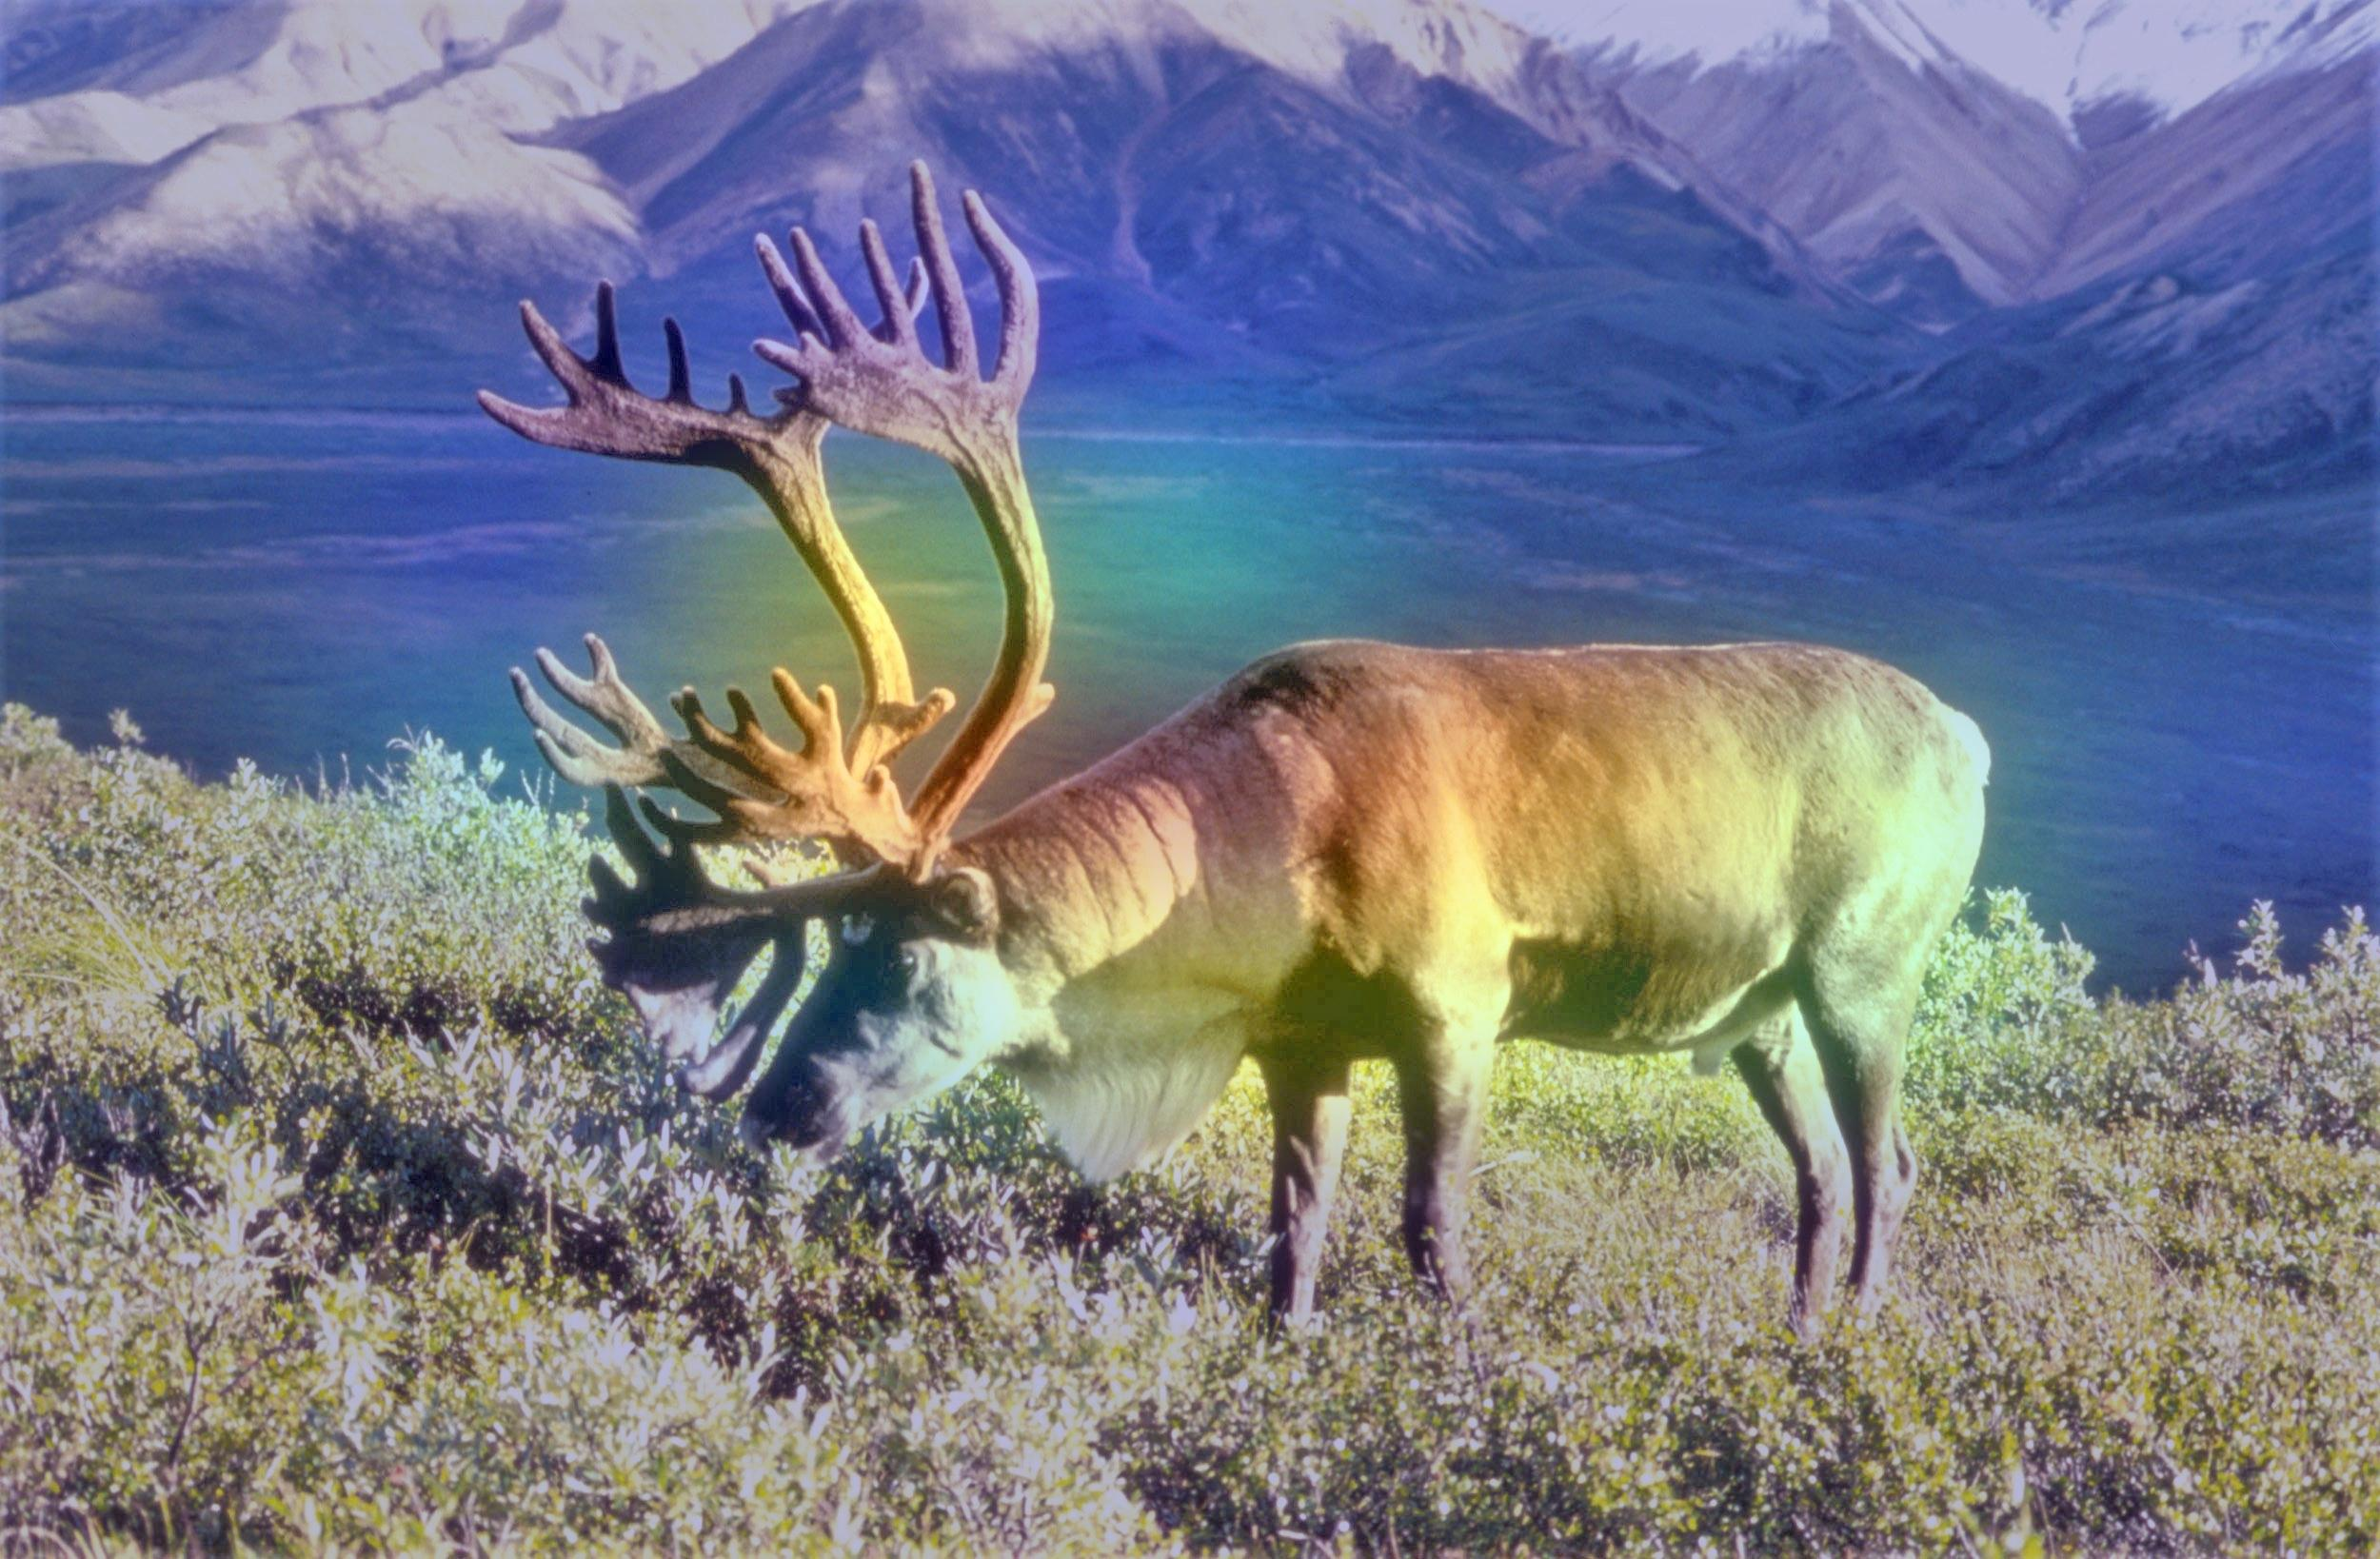

In [203]:

save_and_display_gradcam(grad_cam_img_path, heatmap)